In [19]:
import pandas as pd
import matplotlib.pyplot as plt    
import numpy as np

# Assignment 1

## Tasks 2 
Data Aquisition and Initial Visualisation

## Data
- ID 13306385 is NAPIAS CREEK BELOW ARNETT CREEK NEAR LEESBURG, ID. This is a HEADWATER site
- ID 13039500 is HENRYS FORK NR LAKE ID, below Henrys Lake. This a site below a reservoir
- ID 13237920 is MIDDLE FORK PAYETTE RIVER NR CROUCH ID. This is a HEADWATER site
- ID 13247500 is PAYETTE RIVER NR HORSESHOE BEND ID. This is below a damn somewhere upstream, but also has other upstream free flowing tributaries. 

In [20]:
#load data 

napias_creek = pd.read_csv('../data/13306385_1980_2020.csv')
henrys_fork = pd.read_csv('../data/13039500_1980_2020.csv')
mf_payette = pd.read_csv('../data/13237920_1980_2020.csv')
payette = pd.read_csv('../data/13247500_1980_2020.csv')

In [21]:

payette.describe() #I used this function to inspect the data and found that it looks good, 
#does not appear that any cleaning needs to be done

#The payette river did have a max that appeared to be an outlier, 
# but I looked into it and it turned out to be a massive rainstorm




,USGS_flow,USGS_ID,series
count,11400.000000,12345.0,12345.0
mean,3036.955717,13247500.0,0.0
std,2685.851410,0.0,0.0
min,514.711360,13247500.0,0.0
25%,1080.078075,13247500.0,0.0
50%,2127.552100,13247500.0,0.0
75%,3732.153675,13247500.0,0.0
max,21450.000000,13247500.0,0.0


In [22]:

payette.head()




,Datetime,USGS_flow,variable,USGS_ID,measurement_unit,qualifiers,series
0,1986-12-13,939.4627,streamflow,13247500,ft3/s,['A'],0
1,1986-12-14,1002.7143,streamflow,13247500,ft3/s,['A'],0
2,1986-12-15,1091.4706,streamflow,13247500,ft3/s,['A'],0
3,1986-12-16,1002.5357,streamflow,13247500,ft3/s,"['A', '[91]']",0
4,1986-12-17,NaN,streamflow,13247500,ft3/s,"['A', '[91]']",0


In [23]:

#defines a function that reorganizes the data and can be applied to each 
def clean_usgs(df, flow_name):
    df = df.copy()
    
    # Keep only relevant columns (adjust if needed)
    df = df[['Datetime', 'USGS_flow',]]
    
    # Rename columns
    df.columns = ['date', flow_name]
    
    # Convert date
    df['date'] = pd.to_datetime(df['date'])
    
    # Set index
    df = df.set_index('date')
    
    return df

# Apply the cleaning function to each dataset
napias_creek = clean_usgs(napias_creek, 'Napias Creek')
henrys_fork = clean_usgs(henrys_fork, 'Henrys Fork')
mf_payette = clean_usgs(mf_payette, 'MF Payette')
payette = clean_usgs(payette, 'Payette')

In [24]:
# Merge all streams on date index
df = napias_creek.join([henrys_fork, mf_payette, payette], how='inner')

In [25]:
df.head()

,Napias Creek,Henrys Fork,MF Payette,Payette
date,,,,
1999-10-01,8.500000,49.206184,99.668050,1698.1250
1999-10-02,8.286458,49.072166,99.020836,1656.6666
1999-10-03,8.690625,49.092785,99.114586,1603.6459
1999-10-04,8.987500,49.113403,98.437500,1600.3125
1999-10-05,8.993750,49.061855,98.125000,1599.8959


In [26]:
print(df.index.min(), df.index.max())

1999-10-01 00:00:00 2020-09-29 00:00:00


In [27]:
# Subset to 6 years of data (2014 through the end of 2019)
df_6yr = df.loc['2014-01-01':'2019-12-31']

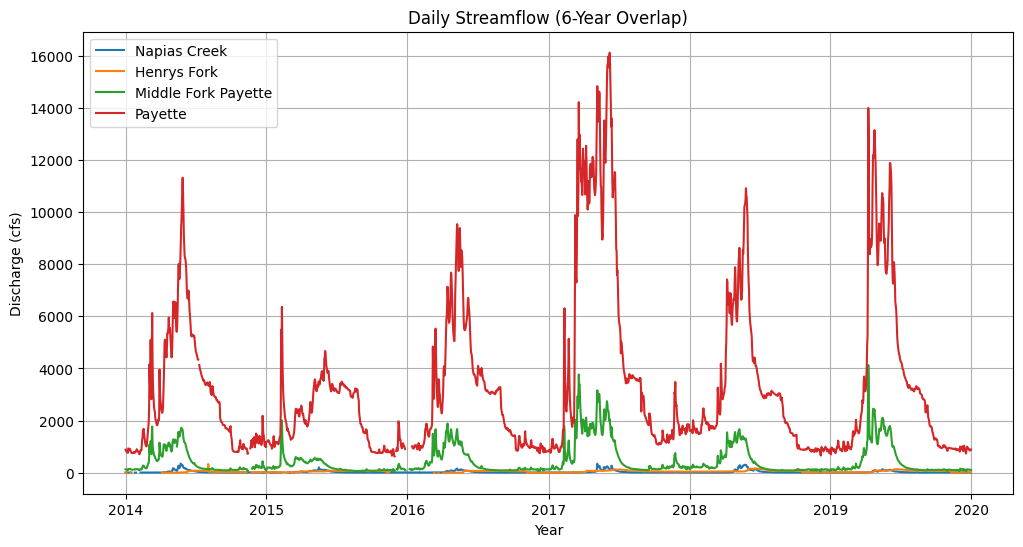

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_6yr.index, df_6yr['Napias Creek'], label='Napias Creek')
plt.plot(df_6yr.index, df_6yr['Henrys Fork'], label='Henrys Fork')
plt.plot(df_6yr.index, df_6yr['MF Payette'], label='Middle Fork Payette')
plt.plot(df_6yr.index, df_6yr['Payette'], label='Payette')

plt.title('Daily Streamflow (6-Year Overlap)')
plt.xlabel('Year')
plt.ylabel('Discharge (cfs)')
plt.legend()
plt.grid(True)
plt.show()

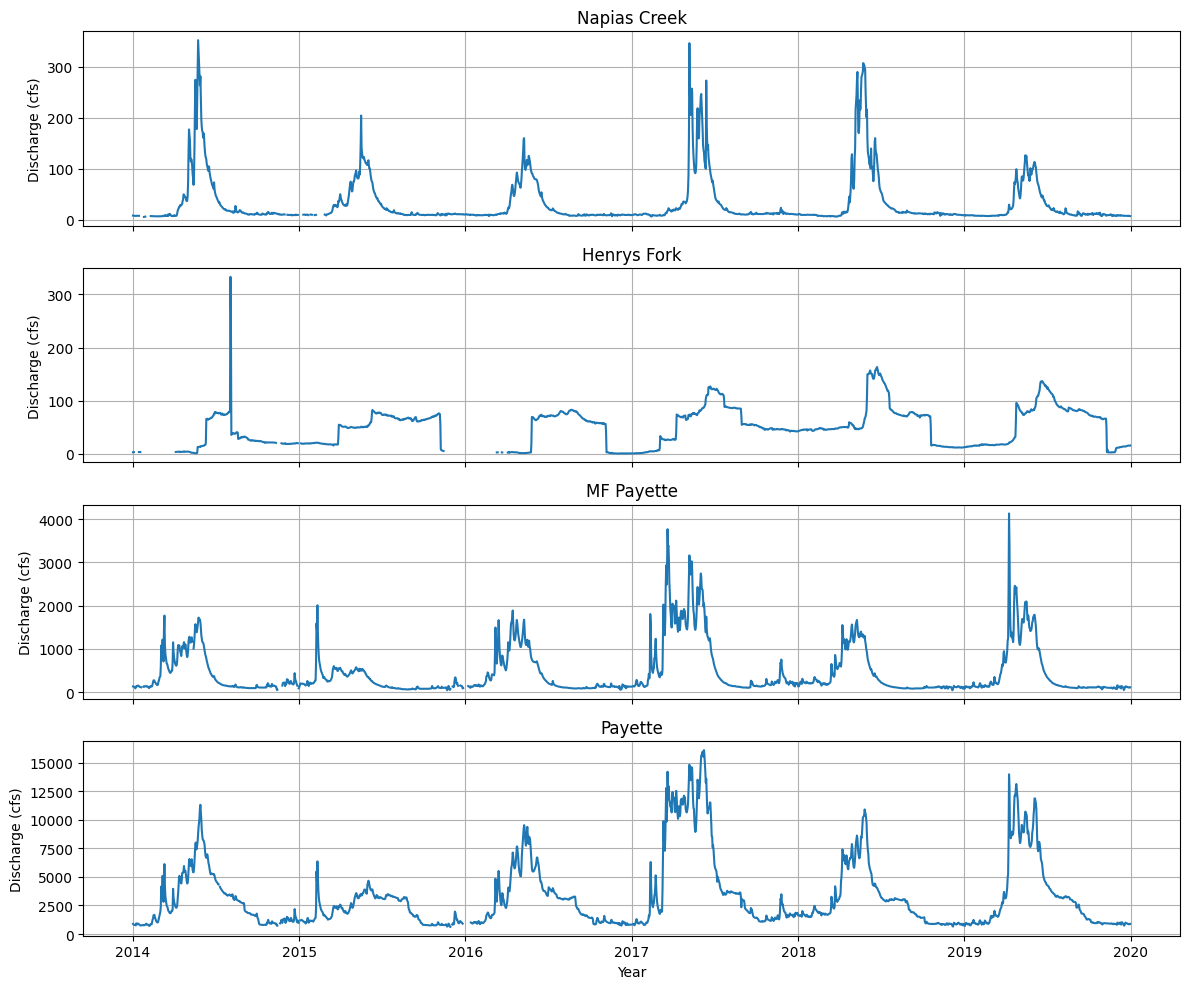

In [29]:
fig, axs = plt.subplots(4, 1, figsize=(12,10), sharex=True)

streams = df_6yr.columns

for i, stream in enumerate(streams):
    axs[i].plot(df_6yr.index, df_6yr[stream])
    axs[i].set_title(stream)
    axs[i].set_ylabel('Discharge (cfs)')
    axs[i].grid(True)

axs[-1].set_xlabel('Year')

plt.tight_layout()
plt.show()

## Task 3
Temporal Resampling & Statistical Aggregation


In [30]:
weekly_mean = df_6yr.resample('W').mean()

In [31]:
# Convert daily discharge (cfs) to daily volume (cubic feet)
daily_volume_cf = df_6yr * 86400

# Monthly total volume
monthly_volume = daily_volume_cf.resample('M').sum()

monthly_volume_af = monthly_volume / 43560

/scratch/local/u1405836/889651/ipykernel_1075105/785867442.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volume = daily_volume_cf.resample('M').sum()


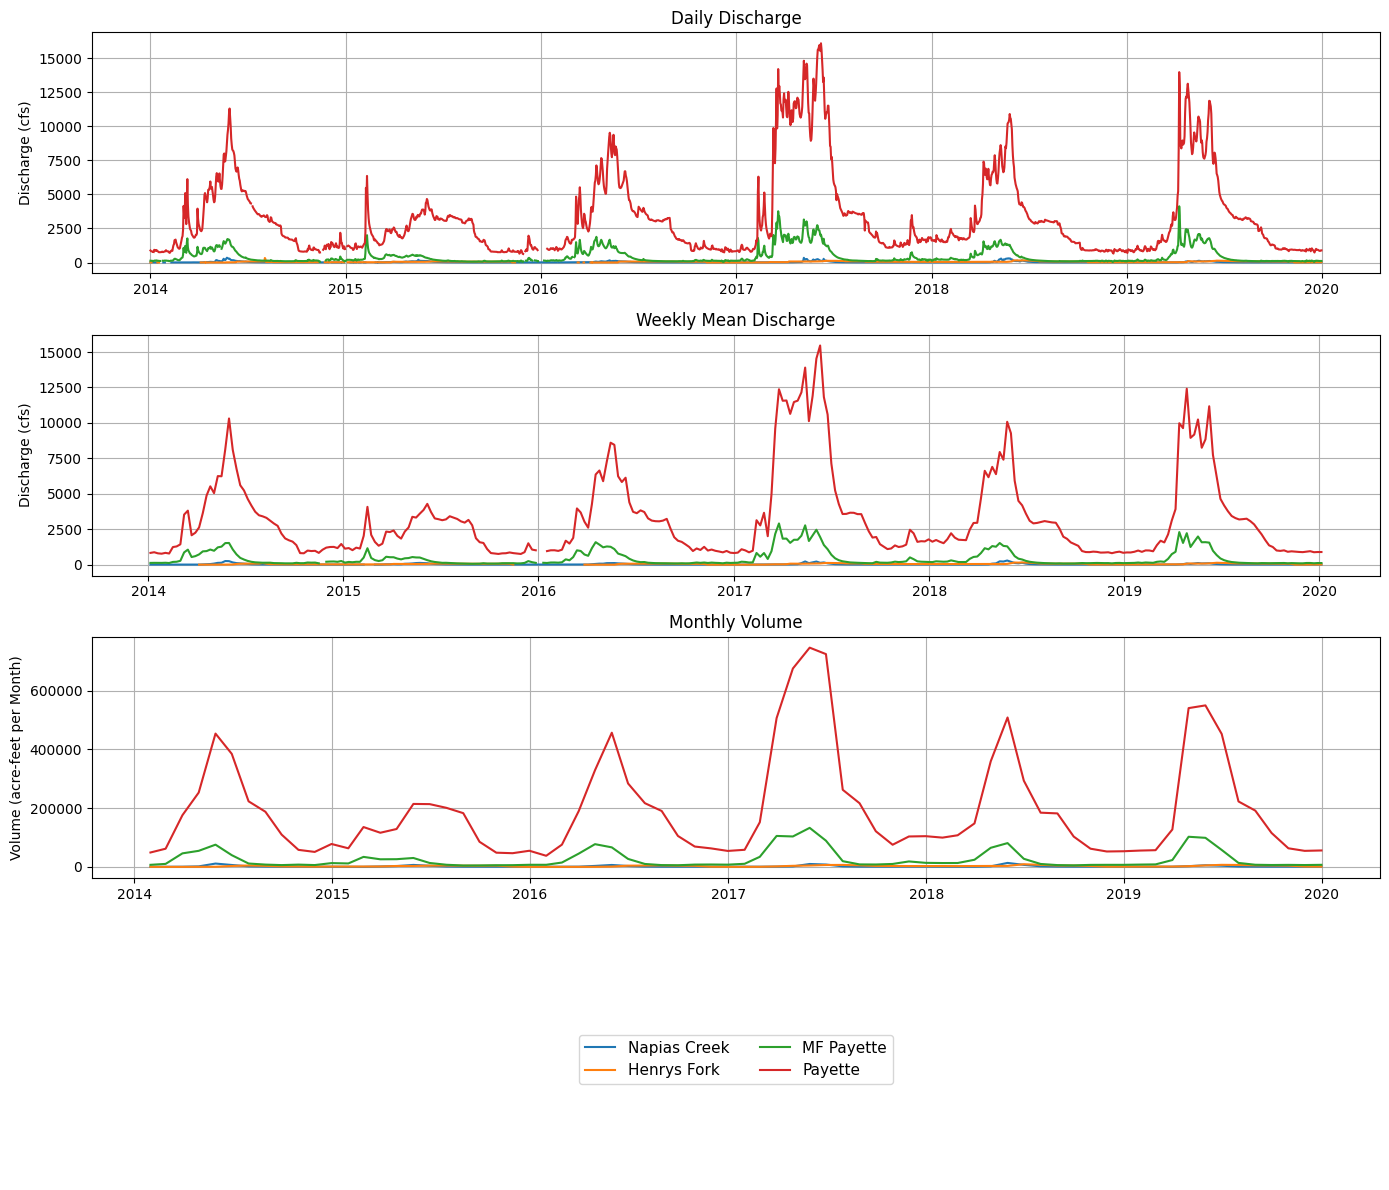

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=False)

# -----------------------
# Panel A — Daily
# -----------------------
lines = []
labels = []

for col in df_6yr.columns:
    line, = axs[0].plot(df_6yr.index, df_6yr[col], label=col)
    lines.append(line)
    labels.append(col)

axs[0].set_title('Daily Discharge')
axs[0].set_ylabel('Discharge (cfs)')
axs[0].grid(True)

# -----------------------
# Panel B — Weekly Mean
# -----------------------
for col in weekly_mean.columns:
    axs[1].plot(weekly_mean.index, weekly_mean[col])

axs[1].set_title('Weekly Mean Discharge')
axs[1].set_ylabel('Discharge (cfs)')
axs[1].grid(True)

# -----------------------
# Panel C — Monthly Volume
# -----------------------
for col in monthly_volume_af.columns:
    axs[2].plot(monthly_volume_af.index, monthly_volume_af[col])

axs[2].set_title('Monthly Volume')
axs[2].set_ylabel('Volume (acre-feet per Month)')
axs[2].grid(True)

# -----------------------
# Panel D — Legend Only (FIXED)
# -----------------------
axs[3].axis('off')
axs[3].legend(lines, labels, loc='center', ncol=2, fontsize=11)

plt.tight_layout()
plt.show()

## Task 4
  
Comparative Analysis

In [33]:


import numpy as np

def plot_flow_range(df, stream_name, year, ax, title):

    temp = df.copy()
    temp["DOY"] = temp.index.dayofyear
    temp["Year"] = temp.index.year

    # Select only chosen year
    selected = temp[temp["Year"] == year]

    if selected.empty:
        print(f"No data found for year {year}")
        return

    # Compute 6-year envelope
    envelope = temp.groupby("DOY")[stream_name].agg(["min", "max"])

    # Plot envelope
    ax.fill_between(
        envelope.index,
        envelope["min"],
        envelope["max"],
        alpha=0.3,
        label="6-Year Range"
    )

    # Plot selected year
    ax.plot(
        selected["DOY"],
        selected[stream_name],
        linewidth=2,
        label=f"{year}"
    )

    # -------- FIX: show month names instead of day numbers --------

    month_starts = [1,32,60,91,121,152,182,213,244,274,305,335]
    month_labels = ['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec']

    ax.set_xticks(month_starts)
    ax.set_xticklabels(month_labels)

    ax.set_xlim(1,365)

    # --------------------------------------------------------------

    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("Discharge (cfs)")
    ax.grid(True)
    ax.legend()

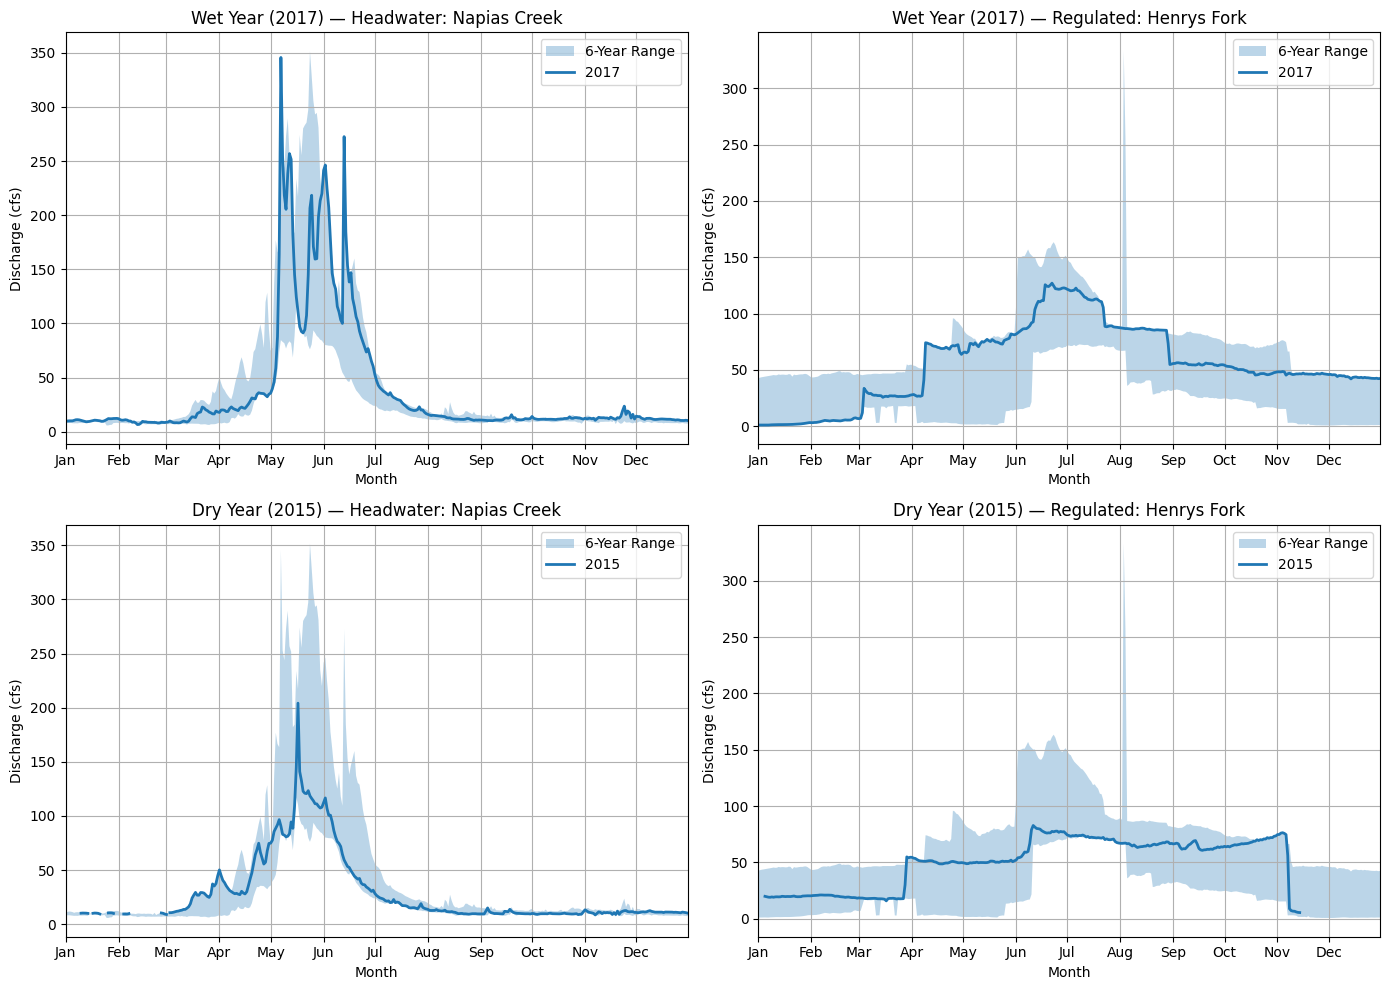

In [36]:
wet_year = 2017      
dry_year = 2015


fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Wet year — Headwater
plot_flow_range(
    df_6yr,   # <-- USE df_6yr HERE
    'Napias Creek',
    wet_year,
    axs[0,0],
    f"Wet Year ({wet_year}) — Headwater: Napias Creek"
)

# Wet year — Regulated
plot_flow_range(
    df_6yr,
    'Henrys Fork',
    wet_year,
    axs[0,1],
    f"Wet Year ({wet_year}) — Regulated: Henrys Fork"
)

# Dry year — Headwater
plot_flow_range(
    df_6yr,
    'Napias Creek',
    dry_year,
    axs[1,0],
    f"Dry Year ({dry_year}) — Headwater: Napias Creek"
)

# Dry year — Regulated
plot_flow_range(
    df_6yr,
    'Henrys Fork',
    dry_year,
    axs[1,1],
    f"Dry Year ({dry_year}) — Regulated: Henrys Fork"
)

plt.tight_layout()
plt.show()